In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import logging
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import helpers as hp

In [3]:
tf.get_logger().setLevel(logging.ERROR)

In [4]:
commands, nums = hp.get_commands_dict('commands.csv')

In [5]:
all_speakers = ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
dataset = dict()
for speaker in all_speakers:
    data = hp.load_from_datafile(f'data/{speaker}_data.npy')
    labels = hp.load_from_datafile(f'data/{speaker}_labels.npy')

    data = data.reshape(data.shape + (1,))
    labels = to_categorical([hp.get_num_by_command(label, commands) for label in labels], num_classes=11)
    idx = np.random.permutation(data.shape[0])
    data, labels = data[idx], labels[idx]
    
    dataset[speaker] = {
        'data':   data,
        'labels': labels 
    }
    
    print(f'{speaker} data shape: {dataset[speaker]["data"].shape}')
    print(f'{speaker} labels shape: {dataset[speaker]["labels"].shape}')

speaker1 data shape: (550, 400, 13, 1)
speaker1 labels shape: (550, 11)
speaker2 data shape: (440, 400, 13, 1)
speaker2 labels shape: (440, 11)
speaker3 data shape: (440, 400, 13, 1)
speaker3 labels shape: (440, 11)
speaker4 data shape: (440, 400, 13, 1)
speaker4 labels shape: (440, 11)
speaker5 data shape: (550, 400, 13, 1)
speaker5 labels shape: (550, 11)
speaker6 data shape: (550, 400, 13, 1)
speaker6 labels shape: (550, 11)


In [6]:
test_size = 0.3
cnn_test_summary = []
mlp_test_summary = []
threshold_list = [0.5, 0.6, 0.7, 0.8]

In [7]:
def run_experiment(experiment_num, train_list, test_list, train_list_shortname, nn_type, 
                   threshold_list, plot_model=False, plot_cm=True, 
                   cm_save_path=None, tg_save=False):
    print('='*10) 
    print(f'Running experiment\n',
          f'Train dataset : {train_list}\n',
          f'Test dataset : {test_list}\n',
          f'Network type is {nn_type.upper()}.')
    # Set train data
    train_data = []
    train_labels = []
    for speaker in train_list:
        train_data.append(dataset[speaker]['data'][:np.floor(dataset[speaker]['data'].shape[0]*(1-test_size)).astype(int), ...])
        train_labels.append(dataset[speaker]['labels'][:np.floor(dataset[speaker]['labels'].shape[0]*(1-test_size)).astype(int), ...])
    train_data = np.concatenate(train_data, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)
    
    # Set test data
    test_data = []
    test_labels = []
    test_dict = dict()
    for speaker in test_list:
        test_data.append(dataset[speaker]['data'][np.floor(dataset[speaker]['data'].shape[0]*(1-test_size)).astype(int):, ...])
        test_labels.append(dataset[speaker]['labels'][np.floor(dataset[speaker]['labels'].shape[0]*(1-test_size)).astype(int):, ...])
        test_dict[speaker] = {
            'data': dataset[speaker]['data'][np.floor(dataset[speaker]['data'].shape[0]*(1-test_size)).astype(int):, ...] ,
            'labels': dataset[speaker]['labels'][np.floor(dataset[speaker]['labels'].shape[0]*(1-test_size)).astype(int):, ...]
        }
    test_data = np.concatenate(test_data, axis=0)
    test_labels = np.concatenate(test_labels, axis=0)
        
    print('---Train dataset---')
    print(f'Contains speakers : {train_list}')
    print(f'data shape : {train_data.shape}')
    print(f'labels shape : {train_labels.shape}')
    
    print('---Test dataset---')
    print(f'Contains speakers : {test_list}')
    for speaker in test_list:
        print(f'{speaker} data shape : {test_dict[speaker]["data"].shape}')
        print(f'{speaker} labels shape : {test_dict[speaker]["labels"].shape}')
    
    # Train
    if nn_type == 'mlp':
        model = hp.get_mlp_model()
        if plot_model:
            tf.keras.utils.plot_model(model, to_file='article/img/mlp_model.png')
    elif nn_type == 'cnn':
        model = hp.get_cnn_model()
        if plot_model:
            tf.keras.utils.plot_model(model, to_file='article/img/cnn_model.png')
        
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

    checkpoint_best_filepath = f'model_checkpoints/experiment{experiment_num}/{nn_type}/best_only'
    checkpoint_best_only = ModelCheckpoint(save_freq='epoch', save_best_only=True,
                                           filepath=checkpoint_best_filepath, verbose=0) 
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=0)

    print('---Training stage---')
    history = model.fit(train_data, train_labels, epochs=50, batch_size=256, validation_split=0.15, 
                        callbacks=[early_stopping, checkpoint_best_only], 
                        verbose=0)

    tg_save_path = None
    if tg_save:
        tg_save_path = os.path.join('article', 'img', f'{nn_type}_{train_list_shortname}_train_graphs.png')
    hp.plot_metrics(history, save_path=tg_save_path)
    
    # Test
    print('---Testing stage---')
    for speaker in test_list + ['all_speakers']:
        if speaker != 'all_speakers':
            test_loss, test_accuracy = model.evaluate(test_dict[speaker]['data'], test_dict[speaker]['labels'], verbose=0)
        else:
            test_loss, test_accuracy = model.evaluate(test_data, test_labels, verbose=0)
            
        print(f"{speaker} - test loss : {test_loss:0.3f} - test accuracy : {test_accuracy:0.3f}")
        
        if nn_type == 'cnn':
            cnn_test_summary.append([train_list_shortname, speaker, round(test_loss, 3), round(test_accuracy, 3)])   
        else:
            mlp_test_summary.append([train_list_shortname, speaker, round(test_loss, 3), round(test_accuracy, 3)])    
    
    if plot_cm:
        cm_arr = list()
        for threshold in threshold_list:
            cm, metrics = hp.get_confusion_matrix(test_labels, model.predict(test_data), nums, threshold=threshold)
            cm_arr.append({
                'cm': cm, 
                'threshold': threshold,
                'metrics': metrics
            })
            
        if cm_save_path:
            cm_save_path = os.path.join('article', 'img', f'{nn_type}_cm_{cm_save_path}.png')
        hp.plot_confusion_matrix(cm_arr, cm_save_path)
        
        prec_df = None
        for cm in cm_arr:
            if prec_df is None:
                prec_df = pd.DataFrame(cm['metrics'], index=hp.get_commands_list_with_silence(nums)).T
                continue
            prec_df = pd.concat((prec_df, pd.DataFrame(cm['metrics'], index=hp.get_commands_list_with_silence(nums)).T))
        prec_df = prec_df[hp.get_commands_list(nums)]
        display(prec_df)
        
        prec_df.to_csv(os.path.join('article', 'csv', f'{nn_type}_{train_list_shortname}_precisions_for_thresholds.csv'), index=True)
        
    
    print('Finished experiment.')
    print('='*10)       

Running experiment
 Train dataset : ['speaker1']
 Test dataset : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
 Network type is CNN.
---Train dataset---
Contains speakers : ['speaker1']
data shape : (385, 400, 13, 1)
labels shape : (385, 11)
---Test dataset---
Contains speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
speaker1 data shape : (165, 400, 13, 1)
speaker1 labels shape : (165, 11)
speaker2 data shape : (132, 400, 13, 1)
speaker2 labels shape : (132, 11)
speaker3 data shape : (132, 400, 13, 1)
speaker3 labels shape : (132, 11)
speaker4 data shape : (132, 400, 13, 1)
speaker4 labels shape : (132, 11)
speaker5 data shape : (165, 400, 13, 1)
speaker5 labels shape : (165, 11)
speaker6 data shape : (165, 400, 13, 1)
speaker6 labels shape : (165, 11)
---Training stage---


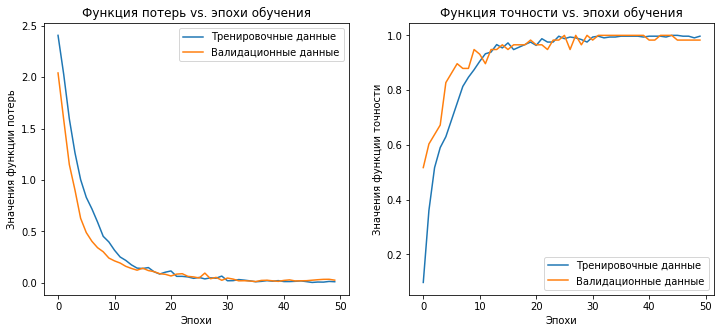

---Testing stage---
speaker1 - test loss : 0.034 - test accuracy : 0.994
speaker2 - test loss : 13.845 - test accuracy : 0.189
speaker3 - test loss : 8.291 - test accuracy : 0.432
speaker4 - test loss : 11.226 - test accuracy : 0.197
speaker5 - test loss : 4.095 - test accuracy : 0.539
speaker6 - test loss : 13.623 - test accuracy : 0.224
all_speakers - test loss : 8.230 - test accuracy : 0.447
Finished experiment.
Running experiment
 Train dataset : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5']
 Test dataset : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
 Network type is CNN.
---Train dataset---
Contains speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5']
data shape : (1694, 400, 13, 1)
labels shape : (1694, 11)
---Test dataset---
Contains speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
speaker1 data shape : (165, 400, 13, 1)
speaker1 labels shape : (165, 11)
speaker2 data shape : (132, 

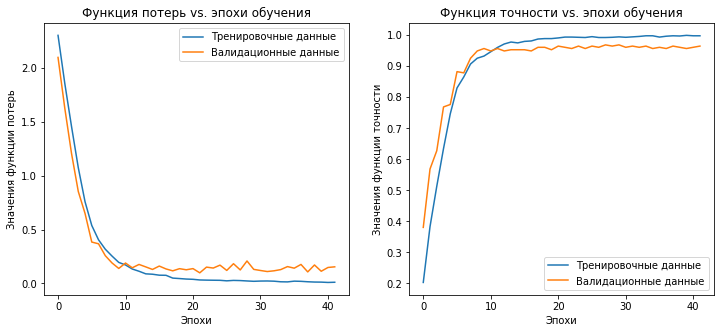

---Testing stage---
speaker1 - test loss : 0.028 - test accuracy : 0.988
speaker2 - test loss : 0.129 - test accuracy : 0.955
speaker3 - test loss : 0.128 - test accuracy : 0.977
speaker4 - test loss : 1.165 - test accuracy : 0.856
speaker5 - test loss : 0.117 - test accuracy : 0.970
speaker6 - test loss : 8.462 - test accuracy : 0.376
all_speakers - test loss : 1.805 - test accuracy : 0.845
Finished experiment.
Running experiment
 Train dataset : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
 Test dataset : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
 Network type is CNN.
---Train dataset---
Contains speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
data shape : (2079, 400, 13, 1)
labels shape : (2079, 11)
---Test dataset---
Contains speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
speaker1 data shape : (165, 400, 13, 1)
speaker1 labels shape : (165, 11)
speaker

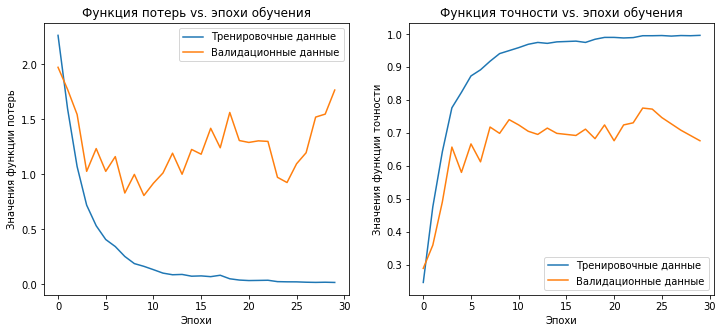

---Testing stage---
speaker1 - test loss : 0.087 - test accuracy : 0.976
speaker2 - test loss : 0.128 - test accuracy : 0.955
speaker3 - test loss : 0.077 - test accuracy : 0.970
speaker4 - test loss : 1.157 - test accuracy : 0.864
speaker5 - test loss : 0.013 - test accuracy : 0.994
speaker6 - test loss : 1.980 - test accuracy : 0.691
all_speakers - test loss : 0.587 - test accuracy : 0.906


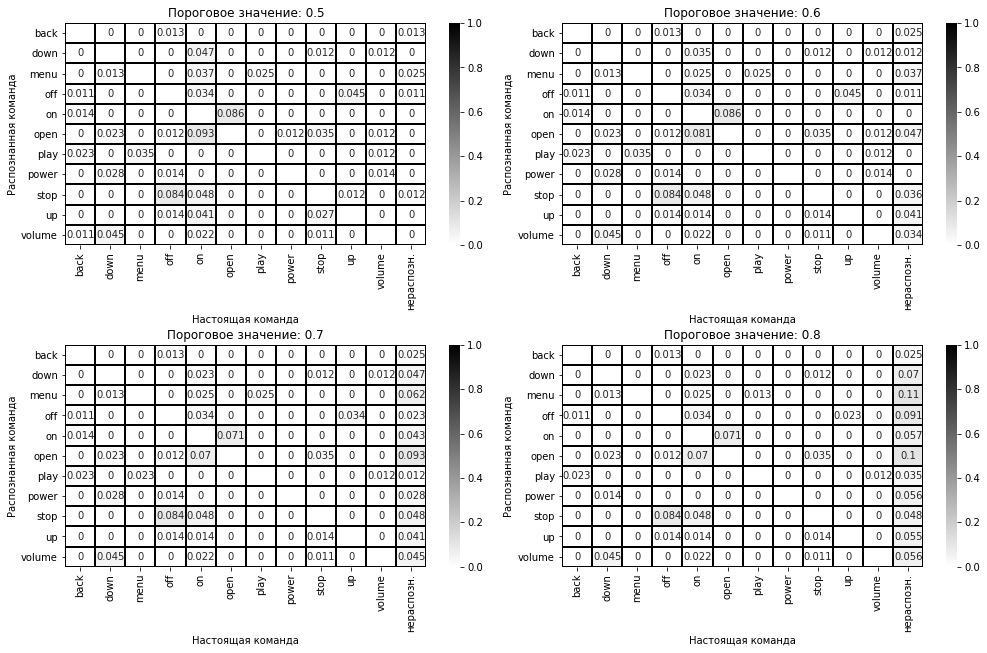

,back,down,menu,off,on,open,play,power,stop,up,volume
precision_for_threshold=0.5,0.975,0.930,0.900,0.898,0.900,0.814,0.93,0.944,0.843,0.918,0.910
precision_for_threshold=0.6,0.962,0.930,0.900,0.898,0.900,0.791,0.93,0.944,0.831,0.918,0.888
precision_for_threshold=0.7,0.962,0.907,0.875,0.898,0.871,0.767,0.93,0.930,0.819,0.918,0.876
precision_for_threshold=0.8,0.962,0.895,0.838,0.841,0.871,0.756,0.93,0.930,0.819,0.904,0.865


Finished experiment.
Running experiment
 Train dataset : ['speaker1']
 Test dataset : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
 Network type is MLP.
---Train dataset---
Contains speakers : ['speaker1']
data shape : (385, 400, 13, 1)
labels shape : (385, 11)
---Test dataset---
Contains speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
speaker1 data shape : (165, 400, 13, 1)
speaker1 labels shape : (165, 11)
speaker2 data shape : (132, 400, 13, 1)
speaker2 labels shape : (132, 11)
speaker3 data shape : (132, 400, 13, 1)
speaker3 labels shape : (132, 11)
speaker4 data shape : (132, 400, 13, 1)
speaker4 labels shape : (132, 11)
speaker5 data shape : (165, 400, 13, 1)
speaker5 labels shape : (165, 11)
speaker6 data shape : (165, 400, 13, 1)
speaker6 labels shape : (165, 11)
---Training stage---


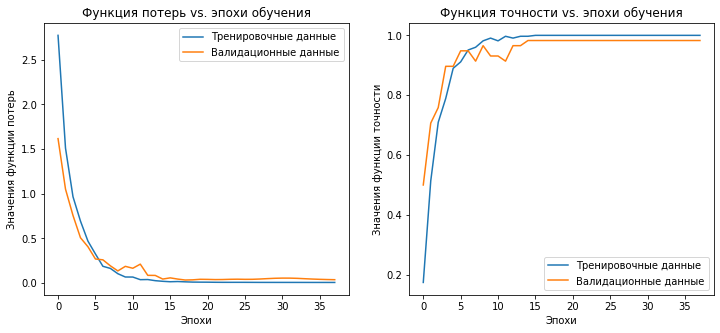

---Testing stage---
speaker1 - test loss : 0.062 - test accuracy : 0.994
speaker2 - test loss : 8.894 - test accuracy : 0.167
speaker3 - test loss : 3.029 - test accuracy : 0.280
speaker4 - test loss : 8.351 - test accuracy : 0.121
speaker5 - test loss : 3.593 - test accuracy : 0.455
speaker6 - test loss : 9.397 - test accuracy : 0.121
all_speakers - test loss : 5.421 - test accuracy : 0.375
Finished experiment.
Running experiment
 Train dataset : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5']
 Test dataset : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
 Network type is MLP.
---Train dataset---
Contains speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5']
data shape : (1694, 400, 13, 1)
labels shape : (1694, 11)
---Test dataset---
Contains speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
speaker1 data shape : (165, 400, 13, 1)
speaker1 labels shape : (165, 11)
speaker2 data shape : (132, 400

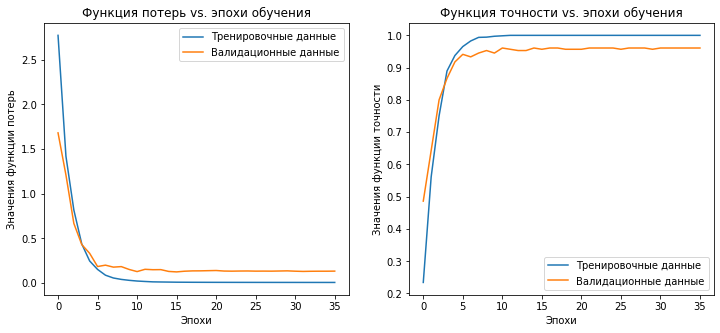

---Testing stage---
speaker1 - test loss : 0.029 - test accuracy : 0.988
speaker2 - test loss : 0.287 - test accuracy : 0.917
speaker3 - test loss : 0.073 - test accuracy : 0.977
speaker4 - test loss : 0.988 - test accuracy : 0.871
speaker5 - test loss : 0.125 - test accuracy : 0.970
speaker6 - test loss : 14.594 - test accuracy : 0.097
all_speakers - test loss : 2.931 - test accuracy : 0.790
Finished experiment.
Running experiment
 Train dataset : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
 Test dataset : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
 Network type is MLP.
---Train dataset---
Contains speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
data shape : (2079, 400, 13, 1)
labels shape : (2079, 11)
---Test dataset---
Contains speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
speaker1 data shape : (165, 400, 13, 1)
speaker1 labels shape : (165, 11)
speake

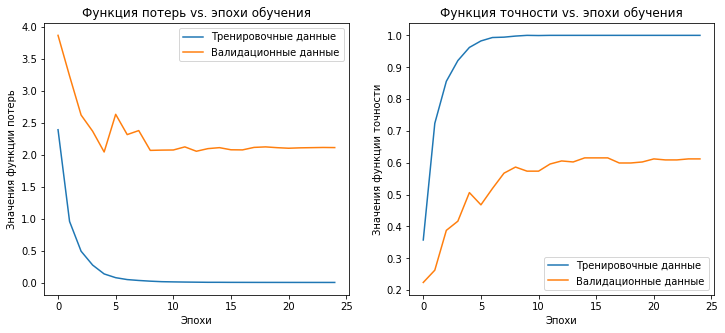

---Testing stage---
speaker1 - test loss : 0.039 - test accuracy : 0.988
speaker2 - test loss : 0.317 - test accuracy : 0.894
speaker3 - test loss : 0.100 - test accuracy : 0.970
speaker4 - test loss : 0.629 - test accuracy : 0.894
speaker5 - test loss : 0.018 - test accuracy : 0.994
speaker6 - test loss : 2.166 - test accuracy : 0.691
all_speakers - test loss : 0.567 - test accuracy : 0.903


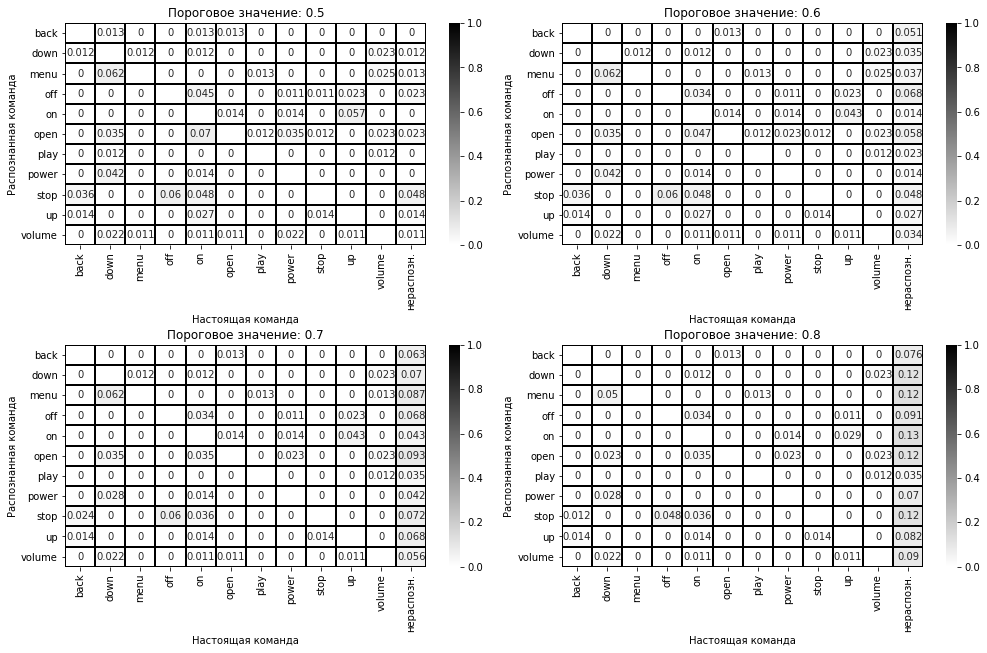

,back,down,menu,off,on,open,play,power,stop,up,volume
precision_for_threshold=0.5,0.962,0.930,0.888,0.886,0.914,0.791,0.977,0.944,0.807,0.932,0.899
precision_for_threshold=0.6,0.937,0.919,0.862,0.864,0.914,0.791,0.965,0.930,0.807,0.918,0.899
precision_for_threshold=0.7,0.924,0.884,0.825,0.864,0.886,0.791,0.953,0.915,0.807,0.890,0.888
precision_for_threshold=0.8,0.911,0.849,0.812,0.864,0.829,0.779,0.953,0.901,0.783,0.877,0.865


Finished experiment.


In [8]:
for nn_type in ['cnn', 'mlp']:
    run_experiment(1, ['speaker1'], all_speakers, 'speaker1', nn_type, threshold_list, True, False, tg_save=True)
    run_experiment(2, ['speaker1','speaker2','speaker3','speaker4','speaker5'], all_speakers, 'all_male_speakers', nn_type, threshold_list, False, False, tg_save=True)
    run_experiment(3, all_speakers, all_speakers, 'all_speakers', nn_type, threshold_list, False, True, 'all_speakers', tg_save=True)

In [9]:
cnn_cols = ['train_data', 'test_data', 'cnn_loss', 'cnn_accuracy']
mlp_cols = ['train_data', 'test_data', 'mlp_loss', 'mlp_accuracy']

compare_order = ['train_data', 'test_data', 'cnn_loss', 'mlp_loss', 'cnn_accuracy', 'mlp_accuracy']
cnn_df = pd.DataFrame(cnn_test_summary, columns=cnn_cols)
mlp_df = pd.DataFrame(mlp_test_summary, columns=mlp_cols)
cols_to_use = mlp_df.columns.difference(cnn_df.columns)
final_df = pd.merge(cnn_df, mlp_df[cols_to_use], left_index=True, right_index=True, how='outer')[compare_order]
pd.set_option('display.max_colwidth', None)
display(final_df)
final_df.to_csv('article/csv/test_summary.csv', index=False)

,train_data,test_data,cnn_loss,mlp_loss,cnn_accuracy,mlp_accuracy
0,speaker1,speaker1,0.034,0.062,0.994,0.994
1,speaker1,speaker2,13.845,8.894,0.189,0.167
2,speaker1,speaker3,8.291,3.029,0.432,0.280
3,speaker1,speaker4,11.226,8.351,0.197,0.121
4,speaker1,speaker5,4.095,3.593,0.539,0.455
5,speaker1,speaker6,13.623,9.397,0.224,0.121
6,speaker1,all_speakers,8.230,5.421,0.447,0.375
7,all_male_speakers,speaker1,0.028,0.029,0.988,0.988
8,all_male_speakers,speaker2,0.129,0.287,0.955,0.917
9,all_male_speakers,speaker3,0.128,0.073,0.977,0.977
